<a href="https://colab.research.google.com/github/chilsan/COMP8325-/blob/main/Groupproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
!pip install tldextract

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [17]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import gc
import random
import os
import pickle
import tensorflow as tf
from tensorflow.python.util import deprecation
from urllib.parse import urlparse
import tldextract
from sklearn.metrics import accuracy_score

In [18]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import models, layers, backend, metrics
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report

In [19]:
# Reading the files into two dataframes.
malicious = pd.read_csv('/content/malicious_dataset.csv')
attack_label = pd.read_csv('/content/attack_labels.csv')
normal = pd.read_csv('/content/normal_dataset.csv')

In [21]:
# Merging the two dataframes, using _ID column as key
merged_data = pd.merge(malicious, attack_label, on = 'ip.src')
merged_data = merged_data.append(normal)
print(merged_data)
merged_data.set_index('ip.src', inplace = True)
# Writing it to a new CSV file named groupproject
merged_data.to_csv('/groupproject.csv')

        frame_info.encap_type                      frame_info.time  \
0                           1  Dec 31, 1969 21:03:41.953641000 -03   
1                           1  Dec 31, 1969 21:03:41.953762000 -03   
2                           1  Dec 31, 1969 21:03:41.953792000 -03   
3                           1  Dec 31, 1969 21:03:41.953817000 -03   
4                           1  Dec 31, 1969 21:03:41.953854000 -03   
...                       ...                                  ...   
103089                      1  Nov 21, 2019 02:01:18.308255000 -03   
103090                      1  Nov 21, 2019 02:01:18.308601000 -03   
103091                      1  Nov 21, 2019 02:01:18.309464000 -03   
103092                      1  Nov 21, 2019 02:01:18.311302000 -03   
103093                      1  Nov 21, 2019 02:01:18.311362000 -03   

        frame_info.time_epoch  frame_info.number  frame_info.len  \
0                2.219536e+02                 20              58   
1                2.2195

In [23]:
# load the dataset 
import pandas as pd
ds = pd.read_csv('/groupproject.csv')
# shuffle the data
ds = ds.sample(frac=1, random_state=0)
print(f'Data size: {ds.shape}')
ds.head()

Data size: (140163, 42)


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (41) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,ip.src,frame_info.encap_type,frame_info.time,frame_info.time_epoch,frame_info.number,frame_info.len,frame_info.cap_len,eth.type,ip.version,ip.hdr_len,...,tcp.flags.reset,tcp.flags.push,tcp.flags.ack,tcp.flags.urg,tcp.flags.cwr,tcp.window_size,tcp.checksum,tcp.urgent_pointer,tcp.options.mss_val,label
13848,172.16.0.16,1,"Dec 31, 1969 21:35:25.379795000 -03",2.125380e+03,26890,78,78,0x00000800,4.0,20.0,...,0.0,0.0,0.0,0.0,0.0,16384.0,0x00003037,0.0,1436.0,unicornscan_tcp_fin
135151,92.192.62.116,1,"Nov 21, 2019 02:01:14.036651000 -03",1.574312e+09,193348,54,54,0x00000800,4.0,20.0,...,0.0,0.0,0.0,0.0,0.0,1024.0,0x00004300,0.0,NaN,NaN
78582,203.180.205.36,1,"Nov 21, 2019 02:00:30.787588000 -03",1.574312e+09,81261,1436,66,0x00000800,4.0,20.0,...,0.0,0.0,1.0,0.0,0.0,245.0,0x000078d6,0.0,NaN,NaN
76409,13.35.206.114,1,"Nov 21, 2019 02:00:29.319744000 -03",1.574312e+09,77018,1440,66,0x00000800,4.0,20.0,...,0.0,0.0,1.0,0.0,0.0,118.0,0x00003ee9,0.0,NaN,NaN
50287,88.162.108.220,1,"Nov 21, 2019 02:00:10.229634000 -03",1.574312e+09,25741,58,58,0x00000800,4.0,20.0,...,0.0,0.0,1.0,0.0,0.0,16384.0,0x00004ef9,0.0,1460.0,NaN


In [24]:
#Feature reduction
ds = ds.drop(['ip.version', 'ip.hdr_len','ip.tos','ip.flags.rb','ip.flags.mf','ip.proto','ip.dst','ip.dsfield','tcp.len','tcp.urgent_pointer','frame_info.time'], axis=1)
ds["label"] = ds["label"].replace(np.nan,"Normal_traffic")
print (ds)

                ip.src  frame_info.encap_type  frame_info.time_epoch  \
13848      172.16.0.16                      1           2.125380e+03   
135151   92.192.62.116                      1           1.574312e+09   
78582   203.180.205.36                      1           1.574312e+09   
76409    13.35.206.114                      1           1.574312e+09   
50287   88.162.108.220                      1           1.574312e+09   
...                ...                    ...                    ...   
41993    13.35.206.114                      1           1.574312e+09   
97639   120.253.44.121                      1           1.574312e+09   
95939    80.99.190.167                      1           1.574312e+09   
117952   13.35.206.114                      1           1.574312e+09   
43567   64.216.120.151                      1           1.574312e+09   

        frame_info.number  frame_info.len  frame_info.cap_len    eth.type  \
13848               26890              78                 

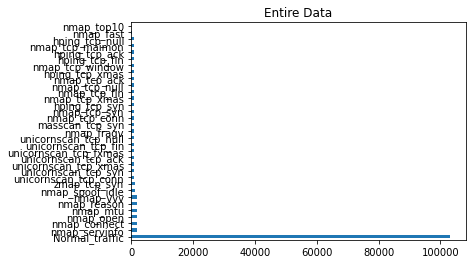

<Figure size 21600x14400 with 0 Axes>

<Figure size 21600x14400 with 0 Axes>

In [27]:
#Data distribustion graph
ds.label.value_counts().plot.barh()
plt.title('Entire Data')
plt.show()
plt.figure(figsize=(300,200))

In [28]:
print (ds.label.value_counts())

Normal_traffic           103094
nmap_servinfo              2016
nmap_connect               2008
nmap_open                  2006
nmap_mtu                   2006
nmap_reason                2006
nmap_vvv                   2002
nmap_spoof_idle            1417
zmap_tcp_syn               1250
unicornscan_tcp_conn       1026
unicornscan_tcp_syn        1017
unicornscan_tcp_xmas       1014
unicornscan_tcp_ack        1014
unicornscan_tcp_fxmas      1014
unicornscan_tcp_fin        1014
unicornscan_tcp_null       1014
nmap_fragv                 1003
masscan_tcp_syn            1003
nmap_tcp_conn              1002
nmap_tcp_syn               1001
hping_tcp_syn              1001
nmap_tcp_xmas              1001
nmap_tcp_fin               1001
nmap_tcp_null              1001
nmap_tcp_ack               1000
hping_tcp_xmas             1000
nmap_tcp_window            1000
hping_tcp_fin              1000
hping_tcp_ack              1000
nmap_tcp_maimon            1000
hping_tcp_null             1000
nmap_fas

In [ ]:
#Models only work with numerical values.Process of converting categorical data into numerical data is called Encoding.
# Encoding features
import struct
from sklearn.preprocessing import LabelEncoder
uniqueval = {}
count=0
for feature in ds["ip.src"] :
#print (feature)
  if feature not in uniqueval :
      uniqueval[feature]=count
      count+=1
      print (uniqueval)
#data.isna()
#data.isnull()
# converting Hex and other strings to float ,int values
      ds["ip.src"].replace({count:uniqueval[count] for count in uniqueval},inplace=True)
      ds["eth.type"].replace({j : struct.unpack('!f', bytes.fromhex(j[2:]))[0] for j in ds["eth.type"] if type(j) != float} , inplace=True)
      ds["ip.id"].replace({ j : struct.unpack('!f', bytes.fromhex(j[2:]))[0] for j in ds["ip.id"] if type(j) != float} , inplace=True )
      ds["ip.checksum"].replace({ j : struct.unpack('!f', bytes.fromhex(j[2:]))[0] for j in ds["ip.checksum"] if type(j) != float} , inplace=True )
      ds["ip.flags"].replace({ j : struct.unpack('!f', bytes.fromhex(j[2:]))[0] for j in ds["ip.flags"] if type(j) != float} , inplace=True)
      ds["tcp.flags"].replace({ j : struct.unpack('!f', bytes.fromhex(j[2:]))[0] for j in ds["tcp.flags"] if type(j) != float} , inplace=True )
      ds["tcp.checksum"].replace({ j : struct.unpack('!f', bytes.fromhex(j[2:]))[0] for j in ds["tcp.checksum"] if type(j) != float} , inplace=True )
      

{'172.16.0.16': 0}


In [3]:
# Replacing NaN values to 0's and printing the resultant data set for reference
import math
data["tcp.options.mss_val"] = data["tcp.options.mss_val"].replace(np.nan,0)
data["ip.id"] = data["ip.id"].replace(np.nan,0)
data["ip.flags"] = data["ip.flags"].replace(np.nan,0)
data["ip.flags.df"] = data["ip.flags.df"].replace(np.nan,0)
data["ip.frag_offset"] = data["ip.frag_offset"].replace(np.nan,0)
data["ip.ttl"] = data["ip.ttl"].replace(np.nan,0)
data["ip.len"] = data["ip.len"].replace(np.nan,0)
data["tcp.srcport"] = data["tcp.srcport"].replace(np.nan,0)
data["tcp.dstport"] = data["tcp.dstport"].replace(np.nan,0)
data["tcp.seq"] = data["tcp.seq"].replace(np.nan,0)
data["tcp.ack"] = data["tcp.ack"].replace(np.nan,0)
data["tcp.hdr_len"] = data["tcp.hdr_len"].replace(np.nan,0)
data["tcp.flags"] = data["tcp.flags"].replace(np.nan,0)
data["tcp.flags.fin"] = data["tcp.flags.fin"].replace(np.nan,0)
data["tcp.flags.syn"] = data["tcp.flags.syn"].replace(np.nan,0)
data["tcp.flags.reset"] = data["tcp.flags.reset"].replace(np.nan,0)
data["tcp.flags.push"] = data["tcp.flags.push"].replace(np.nan,0)
data["tcp.flags.ack"] = data["tcp.flags.ack"].replace(np.nan,0)
data["tcp.flags.urg"] = data["tcp.flags.urg"].replace(np.nan,0)
data["tcp.flags.cwr"] = data["tcp.flags.cwr"].replace(np.nan,0)
data["tcp.window_size"] = data["tcp.window_size"].replace(np.nan,0)
data["tcp.checksum"] = data["tcp.checksum"].replace(np.nan,0)
data["ip.checksum"] = data["ip.checksum"].replace(np.nan,0)
data["ip.id"] = data["ip.id"].replace(np.nan,0)
X = data.iloc[:, 0:30].values
Y = data.iloc[:, 30:].values
z = data.isnull().sum()
z1 = data.isna().sum()
print(z1)
print(Y)
labelencoder_Y = LabelEncoder()
Y = labelencoder_Y.fit_transform(Y)
print(Y)

NameError: ignored